# Multiclass Linear SVC
Per generalizzare il problema su più classi, abbiamo utilizzato OneVsRest con 6 classificatori binari LinearSVC. Gli step effettuati sono i seguenti:
- Importo il dataset
- Elimino attributi categorici e non necessari
- Assemblo le features
- Normalizzo i dati
- Univariate Feature Reduction
- Label encoding (necessario per linearsvc e logistic regression)
- Sampling (solo per il tuning dei parametri)
- Split Training/Test set
- Fitting & Prediction del/i modello/i
- Evaluation

In [2]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer, IndexToString
from pyspark.ml.feature import PCA, UnivariateFeatureSelector
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Multiclass LinearSVC") \
    .getOrCreate()

### Importo il dataset

In [4]:
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
data = data.withColumnRenamed('winPlaceClass', 'label')

In [5]:
data.printSchema()

root
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- isFirstPerson: boolean (nullable = true)
 |-- matchtype: integer (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- hasDisconnected: integer (nullable = true)
 |-- assist_SUM: integer (nullable = true)
 |-- assist_MAX: integer (nullable = true)
 |-- assist_AVG: integer (nullable = true)
 |-- heals_SUM: integer (nullable = true)
 |-- heals_MAX: integer (nullable = true)
 |-- heals_AVG: integer (nullable = true)
 |-- kills_SUM: integer (nullable = true)
 |-- kills_MAX: integer (nullable = true)
 |-- kills_AVG: integer (nullable = true)
 |-- headshotKills_SUM: integer (nullable = true)
 |-- headshotKills_MAX: integer (nullable = true)
 |-- headshotKills_AVG: integer (nullable = true)
 |-- killStreaks_MAX: integer (nullable = true)
 |-- roadKills_SUM: integer (nullab

In [6]:
# Elimino gli attributi non necessari
inputCols =  data.columns
toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label','isFirstPerson']
inputCols = list(set(inputCols) - set(toRemove))

#### Assemblo le features

In [16]:
assemble = VectorAssembler(inputCols = inputCols, outputCol = 'features')
data = assemble.transform(data)

In [17]:
data.select("features","label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(50,[0,1,2,3,8,9,...|    4|
|(50,[1,2,3,8,9,13...|    4|
|(50,[0,1,2,3,9,13...|    4|
|(50,[1,2,3,4,8,9,...|    2|
|(50,[0,1,2,3,8,9,...|    4|
+--------------------+-----+
only showing top 5 rows



#### Normalizzo i dati

In [18]:
scaler = MinMaxScaler(inputCol='features',outputCol="scaled")
data = scaler.fit(data).transform(data)

In [19]:
data.select("scaled","label").show(5)

+--------------------+-----+
|              scaled|label|
+--------------------+-----+
|(50,[0,1,2,3,8,9,...|    4|
|(50,[1,2,3,8,9,13...|    4|
|(50,[0,1,2,9,13,2...|    4|
|(50,[1,2,4,8,9,10...|    2|
|(50,[0,1,2,3,8,9,...|    4|
+--------------------+-----+
only showing top 5 rows



#### Univariate Feature Selector

In [20]:
selector = UnivariateFeatureSelector(featuresCol='scaled',labelCol='label',outputCol='selected')
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(25)
data = selector.fit(data).transform(data)

In [21]:
data.select("selected","label").show(5)

+--------------------+-----+
|            selected|label|
+--------------------+-----+
|(25,[0,1,2,3,8,9,...|    4|
|(25,[1,2,3,8,9,13...|    4|
|(25,[0,1,2,9,13,2...|    4|
|(25,[1,2,4,8,9,10...|    2|
|(25,[0,1,2,3,8,9,...|    4|
+--------------------+-----+
only showing top 5 rows



#### Labels encoding

In [22]:
encoder = StringIndexer(inputCol="label", outputCol="label_enc",handleInvalid='keep')
model_enc = encoder.fit(data)
data = model_enc.transform(data)

In [23]:
data.select("selected","label","label_enc").show(5)

+--------------------+-----+---------+
|            selected|label|label_enc|
+--------------------+-----+---------+
|(25,[0,1,2,3,8,9,...|    4|      0.0|
|(25,[1,2,3,8,9,13...|    4|      0.0|
|(25,[0,1,2,9,13,2...|    4|      0.0|
|(25,[1,2,4,8,9,10...|    2|      3.0|
|(25,[0,1,2,3,8,9,...|    4|      0.0|
+--------------------+-----+---------+
only showing top 5 rows



In [24]:
data.select("label").groupby("label").count().sort("label").show(10)

+-----+------+
|label| count|
+-----+------+
|    1| 47115|
|    2|471233|
|    3|471681|
|    4|496460|
|    5|480416|
|    6| 47185|
+-----+------+



In [25]:
data.select("label_enc").groupby("label_enc").count().sort("label_enc").show(10)

+---------+------+
|label_enc| count|
+---------+------+
|      0.0|496460|
|      1.0|480416|
|      2.0|471681|
|      3.0|471233|
|      4.0| 47185|
|      5.0| 47115|
+---------+------+



#### Sampling

In [26]:
data = data.sample(withReplacement=False, fraction=1.0, seed=42)

In [27]:
data = data.select("selected","label","label_enc")
data = data.withColumnRenamed("selected", "features")
data.show(5)

+--------------------+-----+---------+
|            features|label|label_enc|
+--------------------+-----+---------+
|(25,[0,1,2,3,8,9,...|    4|      0.0|
|(25,[1,2,3,8,9,13...|    4|      0.0|
|(25,[0,1,2,9,13,2...|    4|      0.0|
|(25,[1,2,4,8,9,10...|    2|      3.0|
|(25,[0,1,2,3,8,9,...|    4|      0.0|
+--------------------+-----+---------+
only showing top 5 rows



### Split Training/Test Set

In [28]:
(training,test) = data.randomSplit([0.7,0.3])

print(F'training: {training.count()}')
print(F'test: {test.count()}')

training: 1410211
test: 603879


In [29]:
# ripartizione delle classi - training set
training.select("label").groupby("label").count().sort("label").show(10)

+-----+------+
|label| count|
+-----+------+
|    1| 32995|
|    2|330357|
|    3|330082|
|    4|347694|
|    5|336114|
|    6| 32969|
+-----+------+



In [30]:
# ripartizione delle classi - test set
test.select("label").groupby("label").count().sort("label").show(10)

+-----+------+
|label| count|
+-----+------+
|    1| 14120|
|    2|140876|
|    3|141599|
|    4|148766|
|    5|144302|
|    6| 14216|
+-----+------+



### LinearSVCs

In [31]:
training.show(5)

+----------+-----+---------+
|  features|label|label_enc|
+----------+-----+---------+
|(25,[],[])|    1|      5.0|
|(25,[],[])|    1|      5.0|
|(25,[],[])|    2|      3.0|
|(25,[],[])|    2|      3.0|
|(25,[],[])|    2|      3.0|
+----------+-----+---------+
only showing top 5 rows



In [32]:
svm = LinearSVC( featuresCol='features',
                 labelCol='label_enc',
                 predictionCol='prediction_enc',
                 maxIter=100,
                 regParam=0.05)

ovr = OneVsRest(labelCol='label_enc',
                predictionCol='prediction_enc',
                classifier=svm)

In [33]:
model = ovr.fit(training)

In [34]:
for mod in model.models:
    print(f"Model{mod}:\nWeights:{mod.coefficients}\nIntercept: {mod.intercept}\n")

ModelLinearSVCModel: uid=LinearSVC_e42cf0f267c8, numClasses=2, numFeatures=25:
Weights:[-0.006154483736863086,0.0636724391898451,-0.20571535300220428,-0.00042666171275912917,0.4577245090311635,0.1312524065066752,-0.06193403395544909,0.0139488862114101,0.0046137410728396425,0.30407469816106913,0.02068682211790517,-0.08521062717633077,0.025061735157839115,-0.09614554570834415,-0.007442071844804834,0.0845112689151717,-0.1161292754046503,0.04228329983129796,-0.0022746556353737614,-0.07800070054528986,-0.022258337051310705,-0.07060324510962752,-0.030113802614809042,0.1685416073515886,-0.28447810557382125]
Intercept: -1.0013329764649392

ModelLinearSVCModel: uid=LinearSVC_e42cf0f267c8, numClasses=2, numFeatures=25:
Weights:[0.06750220046858625,-10.185837211557685,-3.6987792020395087,0.7157280662083805,0.6526778855984453,-4.137886078585244,-5.06312627149399,-10.401948210585786,-2.8479421948493457,-74.26979885130821,-0.10831244047799336,-3.4113258585744126,-3.885471620342962,-9.044206080851186

In [35]:
predictions = model.transform(test)
predictions.show(5)

+----------+-----+---------+--------------------+--------------+
|  features|label|label_enc|       rawPrediction|prediction_enc|
+----------+-----+---------+--------------------+--------------+
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|
+----------+-----+---------+--------------------+--------------+
only showing top 5 rows



In [36]:
inv = IndexToString(inputCol="prediction_enc", outputCol="prediction", labels=model_enc.labels)
predictions = inv.transform(predictions)
predictions.show(5)

+----------+-----+---------+--------------------+--------------+----------+
|  features|label|label_enc|       rawPrediction|prediction_enc|prediction|
+----------+-----+---------+--------------------+--------------+----------+
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|         5|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|         5|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|         5|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|         5|
|(25,[],[])|    2|      3.0|[-1.0013329764649...|           1.0|         5|
+----------+-----+---------+--------------------+--------------+----------+
only showing top 5 rows



In [37]:
predictions = predictions.select('features','label','prediction')
predictions = predictions.withColumn("prediction",col("prediction").cast('double'))
predictions.show(5)

+----------+-----+----------+
|  features|label|prediction|
+----------+-----+----------+
|(25,[],[])|    2|       5.0|
|(25,[],[])|    2|       5.0|
|(25,[],[])|    2|       5.0|
|(25,[],[])|    2|       5.0|
|(25,[],[])|    2|       5.0|
+----------+-----+----------+
only showing top 5 rows



### Evaluation

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    #return fig

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [39]:
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00     14120
           2       0.54      0.97      0.69    140876
           3       0.50      0.11      0.17    141599
           4       0.57      0.19      0.29    148766
           5       0.52      0.97      0.67    144302
           6       0.00      0.00      0.00     14216

    accuracy                           0.53    603879
   macro avg       0.35      0.37      0.30    603879
weighted avg       0.50      0.53      0.43    603879



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


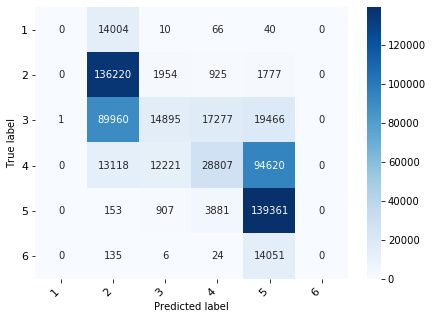

In [41]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names=['1','2','3','4','5','6'],figsize = (7,5), fontsize=11)